<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/GRU/GRU_Cu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [ ]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 119, done.
remote: Counting objects: 100% (119/119), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 119 (delta 53), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (119/119), 107.55 KiB | 5.12 MiB/s, done.
Resolving deltas: 100% (53/53), done.


In [ ]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [ ]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [ ]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [ ]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [ ]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Tue Jul 13 12:28:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [ ]:
# storing the file to be read as a string
in_str = 'Cu'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'GRU'
# setting our window_length to be 30 days
window_len = 30

In [ ]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [ ]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8MB 6.4MB/s 
     |████████████████████████████████| 174kB 56.5MB/s 
     |████████████████████████████████| 102kB 13.1MB/s 
     |████████████████████████████████| 143kB 53.1MB/s 
     |████████████████████████████████| 71kB 9.6MB/s 


In [ ]:
!pip install wandb -qq

In [ ]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'dropout': {
            'values': [0.2, 0.3, 0.4]
        },
        'input_size': {
            'values': [25, 50, 100]
        },
        'hidden_size': {
            'values': [25, 50, 100]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'sgd']
        },
        'activation': {
            'values': ['tanh', 'relu', 'selu']
        }
    }
}

In [ ]:
# The sweep calls this function with each set of hyperparameters
def train():
    # Default values for hyper-parameters we're going to sweep over
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'dropout': 0.2,
        'input_size': 50,
        'hidden_size': 50,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config
    
    # Define the model architecture - This is a simplified version of the VGG19 architecture
    model = Sequential()
    
    # input layer
    model.add(GRU(units=config.input_size,
                  activation=config.activation,
                  return_sequences=True,
                  input_shape=(window_len, 1)))
    model.add(Dropout(config.dropout))
    # hidden layer
    model.add(GRU(units=config.hidden_size))
    model.add(Dropout(config.dropout))
    model.add(Dense(units=1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [ ]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_GRU')

Create sweep with ID: xt8u5110
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_GRU/sweeps/xt8u5110


In [ ]:
# Initialize a new sweep
# Arguments:
#     – sweep_id: the sweep_id to run - this was returned above by wandb.sweep()
#     – function: function that defines your model architecture and trains it
wandb.agent(sweep_id, train, project='ACSE_9_GRU')

wandb: Agent Starting Run: ebb4sd7n with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 50
wandb: 	hidden_size: 25
wandb: 	input_size: 25
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/50
8/8 [==============================] - 22s 155ms/step - loss: 0.2512 - mean_squared_error: 0.2512 - mean_absolute_error: 0.4272 - val_loss: 0.1190 - val_mean_squared_error: 0.1190 - val_mean_absolute_error: 0.2745
Epoch 2/50
8/8 [==============================] - 0s 11ms/step - loss: 0.1256 - mean_squared_error: 0.1256 - mean_absolute_error: 0.2760 - val_loss: 0.0445 - val_mean_squared_error: 0.0445 - val_mean_absolute_error: 0.1580
Epoch 3/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0593 - mean_squared_error: 0.0593 - mean_absolute_error: 0.1834 - val_loss: 0.0207 - val_mean_squared_error: 0.0207 - val_mean_absolute_error: 0.1255
Epoch 4/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0367 - mean_squared_error: 0.0367 - mean_absolute_error: 0.1555 - val_loss: 0.0232 - val_mean_squared_error: 0.0232 - val_mean_absolute_error: 0.1301
Epoch 5/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0443 - mean_squared_error: 0.0443

epoch,49
loss,0.01089
mean_squared_error,0.01089
mean_absolute_error,0.07707
val_loss,0.00564
val_mean_squared_error,0.00564
val_mean_absolute_error,0.05724
_runtime,34
_timestamp,1626108340
_step,49
best_val_loss,0.0056


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇██████
_timestamp,▁▁▁▁▁▁▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇██████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: rded3di9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	epochs: 100
wandb: 	hidden_size: 50
wandb: 	input_size: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/100
31/31 [==============================] - 4s 35ms/step - loss: 0.2933 - mean_squared_error: 0.2933 - mean_absolute_error: 0.4545 - val_loss: 0.0654 - val_mean_squared_error: 0.0654 - val_mean_absolute_error: 0.2301
Epoch 2/100
31/31 [==============================] - 0s 9ms/step - loss: 0.0716 - mean_squared_error: 0.0716 - mean_absolute_error: 0.2291 - val_loss: 0.0589 - val_mean_squared_error: 0.0589 - val_mean_absolute_error: 0.2244
Epoch 3/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0645 - mean_squared_error: 0.0645 - mean_absolute_error: 0.2149 - val_loss: 0.0522 - val_mean_squared_error: 0.0522 - val_mean_absolute_error: 0.2111
Epoch 4/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0563 - mean_squared_error: 0.0563 - mean_absolute_error: 0.2006 - val_loss: 0.0464 - val_mean_squared_error: 0.0464 - val_mean_absolute_error: 0.1985
Epoch 5/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0493 - mean_squared_erro

wandb: Processing terminal ouput (stdout)...
wandb: Done.


epoch,83
loss,0.00643
mean_squared_error,0.00643
mean_absolute_error,0.05858
val_loss,0.00515
val_mean_squared_error,0.00515
val_mean_absolute_error,0.0541
_runtime,31
_timestamp,1626108378
_step,83
best_val_loss,0.00514


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▅▄▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▅▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: xt3b95eu with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	hidden_size: 25
wandb: 	input_size: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/200
8/8 [==============================] - 4s 123ms/step - loss: 0.2214 - mean_squared_error: 0.2214 - mean_absolute_error: 0.4001 - val_loss: 0.0905 - val_mean_squared_error: 0.0905 - val_mean_absolute_error: 0.2247
Epoch 2/200
8/8 [==============================] - 0s 11ms/step - loss: 0.0935 - mean_squared_error: 0.0935 - mean_absolute_error: 0.2448 - val_loss: 0.0440 - val_mean_squared_error: 0.0440 - val_mean_absolute_error: 0.1930
Epoch 3/200
8/8 [==============================] - 0s 13ms/step - loss: 0.0545 - mean_squared_error: 0.0545 - mean_absolute_error: 0.1959 - val_loss: 0.0523 - val_mean_squared_error: 0.0523 - val_mean_absolute_error: 0.1991
Epoch 4/200
8/8 [==============================] - 0s 12ms/step - loss: 0.0591 - mean_squared_error: 0.0591 - mean_absolute_error: 0.2050 - val_loss: 0.0456 - val_mean_squared_error: 0.0456 - val_mean_absolute_error: 0.1885
Epoch 5/200
8/8 [==============================] - 0s 11ms/step - loss: 0.0512 - mean_squared_error: 0.

epoch,108
loss,0.00692
mean_squared_error,0.00692
mean_absolute_error,0.06213
val_loss,0.00487
val_mean_squared_error,0.00487
val_mean_absolute_error,0.05259
_runtime,21
_timestamp,1626108420
_step,108
best_val_loss,0.00484


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▅▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: vd0a4w3v with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	hidden_size: 25
wandb: 	input_size: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/100
16/16 [==============================] - 9s 126ms/step - loss: 0.1023 - mean_squared_error: 0.1023 - mean_absolute_error: 0.2519 - val_loss: 0.0175 - val_mean_squared_error: 0.0175 - val_mean_absolute_error: 0.1039
Epoch 2/100
16/16 [==============================] - 1s 70ms/step - loss: 0.0198 - mean_squared_error: 0.0198 - mean_absolute_error: 0.1053 - val_loss: 0.0064 - val_mean_squared_error: 0.0064 - val_mean_absolute_error: 0.0637
Epoch 3/100
16/16 [==============================] - 1s 70ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0653 - val_loss: 0.0050 - val_mean_squared_error: 0.0050 - val_mean_absolute_error: 0.0527
Epoch 4/100
16/16 [==============================] - 1s 71ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0660 - val_loss: 0.0049 - val_mean_squared_error: 0.0049 - val_mean_absolute_error: 0.0521
Epoch 5/100
16/16 [==============================] - 1s 70ms/step - loss: 0.0062 - mean_squared

epoch,23
loss,0.00449
mean_squared_error,0.00449
mean_absolute_error,0.04997
val_loss,0.00491
val_mean_squared_error,0.00491
val_mean_absolute_error,0.05286
_runtime,39
_timestamp,1626108472
_step,23
best_val_loss,0.00481


epoch,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▃▃▃▃▄▄▅▅▅▅▆▆▆▇▇▇▇██
_timestamp,▁▁▂▂▂▃▃▃▃▄▄▅▅▅▅▆▆▆▇▇▇▇██
_step,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██


wandb: Agent Starting Run: fz6jqdry with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	hidden_size: 100
wandb: 	input_size: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
31/31 [==============================] - 5s 35ms/step - loss: 0.0701 - mean_squared_error: 0.0701 - mean_absolute_error: 0.1664 - val_loss: 0.0087 - val_mean_squared_error: 0.0087 - val_mean_absolute_error: 0.0780
Epoch 2/100
31/31 [==============================] - 0s 10ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0713 - val_loss: 0.0245 - val_mean_squared_error: 0.0245 - val_mean_absolute_error: 0.1333
Epoch 3/100
31/31 [==============================] - 0s 11ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0634 - val_loss: 0.0044 - val_mean_squared_error: 0.0044 - val_mean_absolute_error: 0.0496
Epoch 4/100
31/31 [==============================] - 0s 10ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0615 - val_loss: 0.0056 - val_mean_squared_error: 0.0056 - val_mean_absolute_error: 0.0565
Epoch 5/100
31/31 [==============================] - 0s 9ms/step - loss: 0.0035 - mean_squared_e

epoch,33
loss,0.00173
mean_squared_error,0.00173
mean_absolute_error,0.03238
val_loss,0.00281
val_mean_squared_error,0.00281
val_mean_absolute_error,0.04176
_runtime,20
_timestamp,1626108512
_step,33
best_val_loss,0.0025


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▁▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▄▂▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▂▁▁▁▁▁▁▁▁▂▁
val_loss,▃█▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▃█▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▄█▂▂▂▁▂▃▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: ov2qimym with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	hidden_size: 50
wandb: 	input_size: 25
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/200
8/8 [==============================] - 4s 124ms/step - loss: 0.3170 - mean_squared_error: 0.3170 - mean_absolute_error: 0.4622 - val_loss: 0.0909 - val_mean_squared_error: 0.0909 - val_mean_absolute_error: 0.2604
Epoch 2/200
8/8 [==============================] - 0s 11ms/step - loss: 0.0918 - mean_squared_error: 0.0918 - mean_absolute_error: 0.2475 - val_loss: 0.0726 - val_mean_squared_error: 0.0726 - val_mean_absolute_error: 0.2307
Epoch 3/200
8/8 [==============================] - 0s 11ms/step - loss: 0.0567 - mean_squared_error: 0.0567 - mean_absolute_error: 0.2023 - val_loss: 0.0410 - val_mean_squared_error: 0.0410 - val_mean_absolute_error: 0.1781
Epoch 4/200
8/8 [==============================] - 0s 12ms/step - loss: 0.0414 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1710 - val_loss: 0.0299 - val_mean_squared_error: 0.0299 - val_mean_absolute_error: 0.1558
Epoch 5/200
8/8 [==============================] - 0s 12ms/step - loss: 0.0287 - mean_squared_error: 0.

epoch,42
loss,0.0037
mean_squared_error,0.0037
mean_absolute_error,0.04583
val_loss,0.00508
val_mean_squared_error,0.00508
val_mean_absolute_error,0.05327
_runtime,12
_timestamp,1626108532
_step,42
best_val_loss,0.00505


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▅▄▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇▇█████
_timestamp,▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██


wandb: Agent Starting Run: 034fkqrd with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 50
wandb: 	hidden_size: 25
wandb: 	input_size: 25
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 5s 207ms/step - loss: 0.1947 - mean_squared_error: 0.1947 - mean_absolute_error: 0.3730 - val_loss: 0.0950 - val_mean_squared_error: 0.0950 - val_mean_absolute_error: 0.2471
Epoch 2/50
8/8 [==============================] - 1s 78ms/step - loss: 0.1014 - mean_squared_error: 0.1014 - mean_absolute_error: 0.2546 - val_loss: 0.0370 - val_mean_squared_error: 0.0370 - val_mean_absolute_error: 0.1438
Epoch 3/50
8/8 [==============================] - 1s 76ms/step - loss: 0.0441 - mean_squared_error: 0.0441 - mean_absolute_error: 0.1590 - val_loss: 0.0154 - val_mean_squared_error: 0.0154 - val_mean_absolute_error: 0.1041
Epoch 4/50
8/8 [==============================] - 1s 79ms/step - loss: 0.0304 - mean_squared_error: 0.0304 - mean_absolute_error: 0.1378 - val_loss: 0.0160 - val_mean_squared_error: 0.0160 - val_mean_absolute_error: 0.1079
Epoch 5/50
8/8 [==============================] - 1s 76ms/step - loss: 0.0309 - mean_squared_error: 0.0309 

epoch,43
loss,0.0101
mean_squared_error,0.0101
mean_absolute_error,0.07342
val_loss,0.00578
val_mean_squared_error,0.00578
val_mean_absolute_error,0.05808
_runtime,37
_timestamp,1626108577
_step,43
best_val_loss,0.00569


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: zxzz1aok with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	hidden_size: 100
wandb: 	input_size: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 5s 203ms/step - loss: 0.2782 - mean_squared_error: 0.2782 - mean_absolute_error: 0.4538 - val_loss: 0.1273 - val_mean_squared_error: 0.1273 - val_mean_absolute_error: 0.2840
Epoch 2/100
8/8 [==============================] - 1s 75ms/step - loss: 0.1194 - mean_squared_error: 0.1194 - mean_absolute_error: 0.2776 - val_loss: 0.0245 - val_mean_squared_error: 0.0245 - val_mean_absolute_error: 0.1289
Epoch 3/100
8/8 [==============================] - 1s 79ms/step - loss: 0.0217 - mean_squared_error: 0.0217 - mean_absolute_error: 0.1228 - val_loss: 0.0187 - val_mean_squared_error: 0.0187 - val_mean_absolute_error: 0.1171
Epoch 4/100
8/8 [==============================] - 1s 73ms/step - loss: 0.0154 - mean_squared_error: 0.0154 - mean_absolute_error: 0.1037 - val_loss: 0.0117 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0910
Epoch 5/100
8/8 [==============================] - 1s 75ms/step - loss: 0.0089 - mean_squared_error: 0.

epoch,81
loss,0.00303
mean_squared_error,0.00303
mean_absolute_error,0.04185
val_loss,0.00503
val_mean_squared_error,0.00503
val_mean_absolute_error,0.05277
_runtime,62
_timestamp,1626108646
_step,81
best_val_loss,0.00419


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: edy1so14 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	hidden_size: 50
wandb: 	input_size: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/200
31/31 [==============================] - 6s 105ms/step - loss: 0.3898 - mean_squared_error: 0.3898 - mean_absolute_error: 0.5121 - val_loss: 0.0875 - val_mean_squared_error: 0.0875 - val_mean_absolute_error: 0.2537
Epoch 2/200
31/31 [==============================] - 2s 76ms/step - loss: 0.0756 - mean_squared_error: 0.0756 - mean_absolute_error: 0.2325 - val_loss: 0.0448 - val_mean_squared_error: 0.0448 - val_mean_absolute_error: 0.1926
Epoch 3/200
31/31 [==============================] - 2s 78ms/step - loss: 0.0455 - mean_squared_error: 0.0455 - mean_absolute_error: 0.1788 - val_loss: 0.0319 - val_mean_squared_error: 0.0319 - val_mean_absolute_error: 0.1590
Epoch 4/200
31/31 [==============================] - 2s 72ms/step - loss: 0.0337 - mean_squared_error: 0.0337 - mean_absolute_error: 0.1510 - val_loss: 0.0231 - val_mean_squared_error: 0.0231 - val_mean_absolute_error: 0.1329
Epoch 5/200
31/31 [==============================] - 2s 72ms/step - loss: 0.0278 - mean_squared

epoch,199
loss,0.00392
mean_squared_error,0.00392
mean_absolute_error,0.04769
val_loss,0.00569
val_mean_squared_error,0.00569
val_mean_absolute_error,0.05683
_runtime,471
_timestamp,1626109151
_step,199
best_val_loss,0.0056


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: wiiv9srl with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	hidden_size: 100
wandb: 	input_size: 25
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 5s 142ms/step - loss: 0.3348 - mean_squared_error: 0.3348 - mean_absolute_error: 0.4897 - val_loss: 0.0563 - val_mean_squared_error: 0.0563 - val_mean_absolute_error: 0.1766
Epoch 2/200
8/8 [==============================] - 0s 14ms/step - loss: 0.0407 - mean_squared_error: 0.0407 - mean_absolute_error: 0.1594 - val_loss: 0.0195 - val_mean_squared_error: 0.0195 - val_mean_absolute_error: 0.1190
Epoch 3/200
8/8 [==============================] - 0s 16ms/step - loss: 0.0154 - mean_squared_error: 0.0154 - mean_absolute_error: 0.1051 - val_loss: 0.0124 - val_mean_squared_error: 0.0124 - val_mean_absolute_error: 0.0930
Epoch 4/200
8/8 [==============================] - 0s 16ms/step - loss: 0.0099 - mean_squared_error: 0.0099 - mean_absolute_error: 0.0813 - val_loss: 0.0097 - val_mean_squared_error: 0.0097 - val_mean_absolute_error: 0.0799
Epoch 5/200
8/8 [==============================] - 0s 18ms/step - loss: 0.0077 - mean_squared_error: 0.

epoch,199
loss,0.00207
mean_squared_error,0.00207
mean_absolute_error,0.03441
val_loss,0.00313
val_mean_squared_error,0.00313
val_mean_absolute_error,0.0417
_runtime,37
_timestamp,1626109235
_step,199
best_val_loss,0.00313


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: h2qumhrl with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	hidden_size: 25
wandb: 	input_size: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
31/31 [==============================] - 5s 36ms/step - loss: 0.0920 - mean_squared_error: 0.0920 - mean_absolute_error: 0.2291 - val_loss: 0.0093 - val_mean_squared_error: 0.0093 - val_mean_absolute_error: 0.0737
Epoch 2/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0099 - mean_squared_error: 0.0099 - mean_absolute_error: 0.0760 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - val_mean_absolute_error: 0.0580
Epoch 3/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0626 - val_loss: 0.0052 - val_mean_squared_error: 0.0052 - val_mean_absolute_error: 0.0538
Epoch 4/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0583 - val_loss: 0.0052 - val_mean_squared_error: 0.0052 - val_mean_absolute_error: 0.0537
Epoch 5/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0058 - mean_squared_error: 0.

epoch,49
loss,0.00322
mean_squared_error,0.00322
mean_absolute_error,0.04161
val_loss,0.00379
val_mean_squared_error,0.00379
val_mean_absolute_error,0.0475
_runtime,25
_timestamp,1626109281
_step,49
best_val_loss,0.00331


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▂▁▁▁▁▁▂
val_mean_squared_error,█▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▂▁▁▁▁▁▂
val_mean_absolute_error,█▄▃▃▃▃▃▃▃▄▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▂▁▁▁▁▁▂
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: f75kvc9e with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	hidden_size: 100
wandb: 	input_size: 25
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 5s 130ms/step - loss: 0.2374 - mean_squared_error: 0.2374 - mean_absolute_error: 0.4178 - val_loss: 0.0925 - val_mean_squared_error: 0.0925 - val_mean_absolute_error: 0.2392
Epoch 2/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0761 - mean_squared_error: 0.0761 - mean_absolute_error: 0.2218 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - val_mean_absolute_error: 0.1062
Epoch 3/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0146 - mean_squared_error: 0.0146 - mean_absolute_error: 0.1001 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - val_mean_absolute_error: 0.1068
Epoch 4/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0119 - mean_squared_error: 0.0119 - mean_absolute_error: 0.0921 - val_loss: 0.0120 - val_mean_squared_error: 0.0120 - val_mean_absolute_error: 0.0923
Epoch 5/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0084 - mean_squared_error: 0.

epoch,99
loss,0.00234
mean_squared_error,0.00234
mean_absolute_error,0.03665
val_loss,0.00523
val_mean_squared_error,0.00523
val_mean_absolute_error,0.05605
_runtime,22
_timestamp,1626109313
_step,99
best_val_loss,0.00432


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: uji8pm6r with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	hidden_size: 25
wandb: 	input_size: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 6s 144ms/step - loss: 0.1894 - mean_squared_error: 0.1894 - mean_absolute_error: 0.3377 - val_loss: 0.0317 - val_mean_squared_error: 0.0317 - val_mean_absolute_error: 0.1614
Epoch 2/100
16/16 [==============================] - 1s 76ms/step - loss: 0.0285 - mean_squared_error: 0.0285 - mean_absolute_error: 0.1369 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0787
Epoch 3/100
16/16 [==============================] - 1s 76ms/step - loss: 0.0169 - mean_squared_error: 0.0169 - mean_absolute_error: 0.0950 - val_loss: 0.0069 - val_mean_squared_error: 0.0069 - val_mean_absolute_error: 0.0654
Epoch 4/100
16/16 [==============================] - 1s 76ms/step - loss: 0.0119 - mean_squared_error: 0.0119 - mean_absolute_error: 0.0785 - val_loss: 0.0061 - val_mean_squared_error: 0.0061 - val_mean_absolute_error: 0.0594
Epoch 5/100
16/16 [==============================] - 1s 82ms/step - loss: 0.0108 - mean_squared

epoch,99
loss,0.00403
mean_squared_error,0.00403
mean_absolute_error,0.04533
val_loss,0.0034
val_mean_squared_error,0.0034
val_mean_absolute_error,0.04372
_runtime,136
_timestamp,1626109465
_step,99
best_val_loss,0.00334


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: qcgbz7dl with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	hidden_size: 100
wandb: 	input_size: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
31/31 [==============================] - 7s 107ms/step - loss: 0.0470 - mean_squared_error: 0.0470 - mean_absolute_error: 0.1558 - val_loss: 0.0054 - val_mean_squared_error: 0.0054 - val_mean_absolute_error: 0.0549
Epoch 2/100
31/31 [==============================] - 2s 78ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0549 - val_loss: 0.0049 - val_mean_squared_error: 0.0049 - val_mean_absolute_error: 0.0527
Epoch 3/100
31/31 [==============================] - 2s 77ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0533 - val_loss: 0.0045 - val_mean_squared_error: 0.0045 - val_mean_absolute_error: 0.0493
Epoch 4/100
31/31 [==============================] - 2s 79ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0456 - val_loss: 0.0044 - val_mean_squared_error: 0.0044 - val_mean_absolute_error: 0.0489
Epoch 5/100
31/31 [==============================] - 2s 77ms/step - loss: 0.0033 - mean_squared

epoch,64
loss,0.00158
mean_squared_error,0.00158
mean_absolute_error,0.03004
val_loss,0.00253
val_mean_squared_error,0.00253
val_mean_absolute_error,0.03855
_runtime,163
_timestamp,1626109652
_step,64
best_val_loss,0.00251


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▅▅▄▄▅▃▅▃▃▃▂▃▃▂▂▃▂▂▁▂▁▁▁▁▁▁▂▂▁▂▁▂▃▁▁▁▁
val_mean_squared_error,█▇▆▅▅▄▄▅▃▅▃▃▃▂▃▃▂▂▃▂▂▁▂▁▁▁▁▁▁▂▂▁▂▁▂▃▁▁▁▁
val_mean_absolute_error,█▇▅▅▅▄▄▅▃▆▃▃▃▂▃▃▂▃▄▂▂▂▂▁▁▂▁▁▁▃▃▁▃▁▂▄▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: afbxy55i with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	epochs: 200
wandb: 	hidden_size: 100
wandb: 	input_size: 25
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/200
31/31 [==============================] - 7s 117ms/step - loss: 0.1014 - mean_squared_error: 0.1014 - mean_absolute_error: 0.2474 - val_loss: 0.0136 - val_mean_squared_error: 0.0136 - val_mean_absolute_error: 0.0982
Epoch 2/200
31/31 [==============================] - 3s 87ms/step - loss: 0.0143 - mean_squared_error: 0.0143 - mean_absolute_error: 0.0953 - val_loss: 0.0054 - val_mean_squared_error: 0.0054 - val_mean_absolute_error: 0.0567
Epoch 3/200
31/31 [==============================] - 2s 81ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0678 - val_loss: 0.0052 - val_mean_squared_error: 0.0052 - val_mean_absolute_error: 0.0542
Epoch 4/200
31/31 [==============================] - 2s 75ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0652 - val_loss: 0.0054 - val_mean_squared_error: 0.0054 - val_mean_absolute_error: 0.0565
Epoch 5/200
31/31 [==============================] - 2s 72ms/step - loss: 0.0071 - mean_squared

epoch,12
loss,0.00496
mean_squared_error,0.00496
mean_absolute_error,0.05276
val_loss,0.00525
val_mean_squared_error,0.00525
val_mean_absolute_error,0.05476
_runtime,42
_timestamp,1626109748
_step,12
best_val_loss,0.00519


epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
loss,█▂▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▃▃▄▅▅▆▆▇▇█
_timestamp,▁▂▂▃▃▄▅▅▆▆▇▇█
_step,▁▂▂▃▃▄▅▅▆▆▇▇█


wandb: Agent Starting Run: 3n6ijbuz with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	hidden_size: 25
wandb: 	input_size: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 5s 64ms/step - loss: 0.1098 - mean_squared_error: 0.1098 - mean_absolute_error: 0.2529 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0776
Epoch 2/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0157 - mean_squared_error: 0.0157 - mean_absolute_error: 0.0946 - val_loss: 0.0091 - val_mean_squared_error: 0.0091 - val_mean_absolute_error: 0.0789
Epoch 3/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0714 - val_loss: 0.0053 - val_mean_squared_error: 0.0053 - val_mean_absolute_error: 0.0550
Epoch 4/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0609 - val_loss: 0.0050 - val_mean_squared_error: 0.0050 - val_mean_absolute_error: 0.0529
Epoch 5/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0057 - mean_squared_error

epoch,49
loss,0.00339
mean_squared_error,0.00339
mean_absolute_error,0.04273
val_loss,0.00329
val_mean_squared_error,0.00329
val_mean_absolute_error,0.04273
_runtime,20
_timestamp,1626109777
_step,49
best_val_loss,0.00329


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▃▃▃▃▃▄▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: p7pt16sh with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	hidden_size: 25
wandb: 	input_size: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 5s 143ms/step - loss: 0.1922 - mean_squared_error: 0.1922 - mean_absolute_error: 0.3306 - val_loss: 0.0147 - val_mean_squared_error: 0.0147 - val_mean_absolute_error: 0.1039
Epoch 2/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0139 - mean_squared_error: 0.0139 - mean_absolute_error: 0.0965 - val_loss: 0.0111 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0879
Epoch 3/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - mean_absolute_error: 0.0846 - val_loss: 0.0063 - val_mean_squared_error: 0.0063 - val_mean_absolute_error: 0.0616
Epoch 4/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0610 - val_loss: 0.0064 - val_mean_squared_error: 0.0064 - val_mean_absolute_error: 0.0627
Epoch 5/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0071 - mean_squared_error: 0.

epoch,90
loss,0.00181
mean_squared_error,0.00181
mean_absolute_error,0.03192
val_loss,0.00268
val_mean_squared_error,0.00268
val_mean_absolute_error,0.03929
_runtime,22
_timestamp,1626109818
_step,90
best_val_loss,0.0026


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▁▁▂▁▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▆▄▂▂▂▃▂▂▂▃▂▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▆▄▂▂▂▃▂▂▂▃▂▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▂▂▆▄▂▂▂▄▂▂▂▃▂▂▃▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████


wandb: Agent Starting Run: mxd9mye1 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	hidden_size: 50
wandb: 	input_size: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 5s 199ms/step - loss: 0.1607 - mean_squared_error: 0.1607 - mean_absolute_error: 0.3208 - val_loss: 0.0183 - val_mean_squared_error: 0.0183 - val_mean_absolute_error: 0.1171
Epoch 2/200
8/8 [==============================] - 1s 82ms/step - loss: 0.0308 - mean_squared_error: 0.0308 - mean_absolute_error: 0.1489 - val_loss: 0.0131 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0966
Epoch 3/200
8/8 [==============================] - 1s 74ms/step - loss: 0.0150 - mean_squared_error: 0.0150 - mean_absolute_error: 0.0984 - val_loss: 0.0112 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0790
Epoch 4/200
8/8 [==============================] - 1s 77ms/step - loss: 0.0142 - mean_squared_error: 0.0142 - mean_absolute_error: 0.0872 - val_loss: 0.0067 - val_mean_squared_error: 0.0067 - val_mean_absolute_error: 0.0646
Epoch 5/200
8/8 [==============================] - 1s 79ms/step - loss: 0.0085 - mean_squared_error: 0.

epoch,199
loss,0.00267
mean_squared_error,0.00267
mean_absolute_error,0.03884
val_loss,0.00289
val_mean_squared_error,0.00289
val_mean_absolute_error,0.04067
_runtime,144
_timestamp,1626109976
_step,199
best_val_loss,0.00289


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 6y6zipgx with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	hidden_size: 25
wandb: 	input_size: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 6s 144ms/step - loss: 0.1321 - mean_squared_error: 0.1321 - mean_absolute_error: 0.2776 - val_loss: 0.0159 - val_mean_squared_error: 0.0159 - val_mean_absolute_error: 0.0956
Epoch 2/200
16/16 [==============================] - 1s 82ms/step - loss: 0.0197 - mean_squared_error: 0.0197 - mean_absolute_error: 0.1027 - val_loss: 0.0075 - val_mean_squared_error: 0.0075 - val_mean_absolute_error: 0.0703
Epoch 3/200
16/16 [==============================] - 1s 80ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - mean_absolute_error: 0.0689 - val_loss: 0.0049 - val_mean_squared_error: 0.0049 - val_mean_absolute_error: 0.0520
Epoch 4/200
16/16 [==============================] - 1s 82ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0594 - val_loss: 0.0051 - val_mean_squared_error: 0.0051 - val_mean_absolute_error: 0.0536
Epoch 5/200
16/16 [==============================] - 1s 84ms/step - loss: 0.0066 - mean_squared

epoch,155
loss,0.00152
mean_squared_error,0.00152
mean_absolute_error,0.02952
val_loss,0.00244
val_mean_squared_error,0.00244
val_mean_absolute_error,0.03834
_runtime,211
_timestamp,1626110198
_step,155
best_val_loss,0.0024


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
val_mean_squared_error,█▅▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▄▃▃▃▃▂▃▂▃▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: nwzkqqv9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	hidden_size: 25
wandb: 	input_size: 25
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 6s 131ms/step - loss: 0.3109 - mean_squared_error: 0.3109 - mean_absolute_error: 0.4780 - val_loss: 0.1674 - val_mean_squared_error: 0.1674 - val_mean_absolute_error: 0.3261
Epoch 2/50
16/16 [==============================] - 1s 79ms/step - loss: 0.1682 - mean_squared_error: 0.1682 - mean_absolute_error: 0.3315 - val_loss: 0.0679 - val_mean_squared_error: 0.0679 - val_mean_absolute_error: 0.1937
Epoch 3/50
16/16 [==============================] - 1s 77ms/step - loss: 0.0722 - mean_squared_error: 0.0722 - mean_absolute_error: 0.2160 - val_loss: 0.0243 - val_mean_squared_error: 0.0243 - val_mean_absolute_error: 0.1307
Epoch 4/50
16/16 [==============================] - 1s 76ms/step - loss: 0.0272 - mean_squared_error: 0.0272 - mean_absolute_error: 0.1309 - val_loss: 0.0092 - val_mean_squared_error: 0.0092 - val_mean_absolute_error: 0.0764
Epoch 5/50
16/16 [==============================] - 1s 83ms/step - loss: 0.0161 - mean_squared_erro

epoch,49
loss,0.00704
mean_squared_error,0.00704
mean_absolute_error,0.06334
val_loss,0.0057
val_mean_squared_error,0.0057
val_mean_absolute_error,0.05799
_runtime,74
_timestamp,1626110283
_step,49
best_val_loss,0.00529


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: xk2978kk with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	hidden_size: 100
wandb: 	input_size: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/100
16/16 [==============================] - 6s 134ms/step - loss: 0.1288 - mean_squared_error: 0.1288 - mean_absolute_error: 0.2837 - val_loss: 0.0194 - val_mean_squared_error: 0.0194 - val_mean_absolute_error: 0.1098
Epoch 2/100
16/16 [==============================] - 1s 78ms/step - loss: 0.0163 - mean_squared_error: 0.0163 - mean_absolute_error: 0.0996 - val_loss: 0.0068 - val_mean_squared_error: 0.0068 - val_mean_absolute_error: 0.0657
Epoch 3/100
16/16 [==============================] - 1s 79ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0541 - val_loss: 0.0055 - val_mean_squared_error: 0.0055 - val_mean_absolute_error: 0.0556
Epoch 4/100
16/16 [==============================] - 1s 74ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0478 - val_loss: 0.0056 - val_mean_squared_error: 0.0056 - val_mean_absolute_error: 0.0562
Epoch 5/100
16/16 [==============================] - 1s 72ms/step - loss: 0.0036 - mean_squared

epoch,77
loss,0.00193
mean_squared_error,0.00193
mean_absolute_error,0.03424
val_loss,0.00497
val_mean_squared_error,0.00497
val_mean_absolute_error,0.05263
_runtime,111
_timestamp,1626110421
_step,77
best_val_loss,0.0049


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: sr4aw20m with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	epochs: 100
wandb: 	hidden_size: 50
wandb: 	input_size: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
31/31 [==============================] - 4s 36ms/step - loss: 0.0708 - mean_squared_error: 0.0708 - mean_absolute_error: 0.1906 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0838
Epoch 2/100
31/31 [==============================] - 0s 9ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - mean_absolute_error: 0.0765 - val_loss: 0.0039 - val_mean_squared_error: 0.0039 - val_mean_absolute_error: 0.0460
Epoch 3/100
31/31 [==============================] - 0s 9ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0624 - val_loss: 0.0039 - val_mean_squared_error: 0.0039 - val_mean_absolute_error: 0.0465
Epoch 4/100
31/31 [==============================] - 0s 9ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0543 - val_loss: 0.0048 - val_mean_squared_error: 0.0048 - val_mean_absolute_error: 0.0524
Epoch 5/100
31/31 [==============================] - 0s 9ms/step - loss: 0.0056 - mean_squared_erro

epoch,68
loss,0.00209
mean_squared_error,0.00209
mean_absolute_error,0.03527
val_loss,0.00253
val_mean_squared_error,0.00253
val_mean_absolute_error,0.03793
_runtime,32
_timestamp,1626110465
_step,68
best_val_loss,0.00243


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▃▂▂▃▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▃▂▂▃▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▃▂▂▃▂▁▃▂▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▂▂▁▂▂▁▁▁▁▁▂▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: p2ho6cs0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	hidden_size: 100
wandb: 	input_size: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 5s 63ms/step - loss: 0.0765 - mean_squared_error: 0.0765 - mean_absolute_error: 0.1781 - val_loss: 0.0174 - val_mean_squared_error: 0.0174 - val_mean_absolute_error: 0.1072
Epoch 2/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - mean_absolute_error: 0.0743 - val_loss: 0.0071 - val_mean_squared_error: 0.0071 - val_mean_absolute_error: 0.0652
Epoch 3/200
16/16 [==============================] - 0s 12ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0701 - val_loss: 0.0040 - val_mean_squared_error: 0.0040 - val_mean_absolute_error: 0.0463
Epoch 4/200
16/16 [==============================] - 0s 13ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0430 - val_loss: 0.0044 - val_mean_squared_error: 0.0044 - val_mean_absolute_error: 0.0498
Epoch 5/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0060 - mean_squared_

epoch,80
loss,0.00149
mean_squared_error,0.00149
mean_absolute_error,0.0299
val_loss,0.00266
val_mean_squared_error,0.00266
val_mean_absolute_error,0.03859
_runtime,28
_timestamp,1626110519
_step,80
best_val_loss,0.0024


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▂▃▃▂▂▂▃▂▂▁▁▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▂▃▁▁▁▁▁▃▁▁▁▂▁▂▁▁▁▂▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▂▂▃▁▁▁▁▁▃▁▁▁▂▁▂▁▁▁▂▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▂▂▃▃▂▁▁▁▁▄▂▂▁▃▁▂▁▁▁▃▁▃▁▁▁▁▂▁▃▁▂▁▂▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 2xxrsw43 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	hidden_size: 100
wandb: 	input_size: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/200
8/8 [==============================] - 5s 215ms/step - loss: 0.2465 - mean_squared_error: 0.2465 - mean_absolute_error: 0.4274 - val_loss: 0.1346 - val_mean_squared_error: 0.1346 - val_mean_absolute_error: 0.2843
Epoch 2/200
8/8 [==============================] - 1s 160ms/step - loss: 0.1362 - mean_squared_error: 0.1362 - mean_absolute_error: 0.3026 - val_loss: 0.0605 - val_mean_squared_error: 0.0605 - val_mean_absolute_error: 0.2026
Epoch 3/200
8/8 [==============================] - 1s 85ms/step - loss: 0.0625 - mean_squared_error: 0.0625 - mean_absolute_error: 0.2104 - val_loss: 0.0512 - val_mean_squared_error: 0.0512 - val_mean_absolute_error: 0.2092
Epoch 4/200
8/8 [==============================] - 1s 83ms/step - loss: 0.0507 - mean_squared_error: 0.0507 - mean_absolute_error: 0.1927 - val_loss: 0.0557 - val_mean_squared_error: 0.0557 - val_mean_absolute_error: 0.2115
Epoch 5/200
8/8 [==============================] - 1s 84ms/step - loss: 0.0515 - mean_squared_error: 0

epoch,139
loss,0.00452
mean_squared_error,0.00452
mean_absolute_error,0.05051
val_loss,0.005
val_mean_squared_error,0.005
val_mean_absolute_error,0.05308
_runtime,106
_timestamp,1626110638
_step,139
best_val_loss,0.005


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▅▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▆▅▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▇▆▅▅▅▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: g78ax8wb with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	hidden_size: 100
wandb: 	input_size: 25
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 6s 142ms/step - loss: 0.1426 - mean_squared_error: 0.1426 - mean_absolute_error: 0.2869 - val_loss: 0.0085 - val_mean_squared_error: 0.0085 - val_mean_absolute_error: 0.0761
Epoch 2/100
16/16 [==============================] - 1s 85ms/step - loss: 0.0110 - mean_squared_error: 0.0110 - mean_absolute_error: 0.0815 - val_loss: 0.0067 - val_mean_squared_error: 0.0067 - val_mean_absolute_error: 0.0659
Epoch 3/100
16/16 [==============================] - 1s 82ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0640 - val_loss: 0.0053 - val_mean_squared_error: 0.0053 - val_mean_absolute_error: 0.0542
Epoch 4/100
16/16 [==============================] - 1s 84ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0497 - val_loss: 0.0047 - val_mean_squared_error: 0.0047 - val_mean_absolute_error: 0.0503
Epoch 5/100
16/16 [==============================] - 1s 83ms/step - loss: 0.0043 - mean_squared

epoch,99
loss,0.00145
mean_squared_error,0.00145
mean_absolute_error,0.0295
val_loss,0.00272
val_mean_squared_error,0.00272
val_mean_absolute_error,0.04035
_runtime,142
_timestamp,1626110794
_step,99
best_val_loss,0.0027


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁
val_mean_squared_error,█▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁
val_mean_absolute_error,█▄▃▃▃▃▂▂▂▂▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 0rjk22r0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 100
wandb: 	hidden_size: 100
wandb: 	input_size: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/100
16/16 [==============================] - 6s 178ms/step - loss: 0.3035 - mean_squared_error: 0.3035 - mean_absolute_error: 0.4716 - val_loss: 0.1548 - val_mean_squared_error: 0.1548 - val_mean_absolute_error: 0.3018
Epoch 2/100
16/16 [==============================] - 1s 83ms/step - loss: 0.1472 - mean_squared_error: 0.1472 - mean_absolute_error: 0.3122 - val_loss: 0.0785 - val_mean_squared_error: 0.0785 - val_mean_absolute_error: 0.2279
Epoch 3/100
16/16 [==============================] - 1s 85ms/step - loss: 0.0816 - mean_squared_error: 0.0816 - mean_absolute_error: 0.2422 - val_loss: 0.0645 - val_mean_squared_error: 0.0645 - val_mean_absolute_error: 0.2340
Epoch 4/100
16/16 [==============================] - 1s 82ms/step - loss: 0.0697 - mean_squared_error: 0.0697 - mean_absolute_error: 0.2260 - val_loss: 0.0641 - val_mean_squared_error: 0.0641 - val_mean_absolute_error: 0.2360
Epoch 5/100
16/16 [==============================] - 1s 84ms/step - loss: 0.0665 - mean_squared

epoch,99
loss,0.00687
mean_squared_error,0.00687
mean_absolute_error,0.0642
val_loss,0.00584
val_mean_squared_error,0.00584
val_mean_absolute_error,0.06014
_runtime,141
_timestamp,1626110958
_step,99
best_val_loss,0.00584


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: yhig3ixd with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 100
wandb: 	hidden_size: 100
wandb: 	input_size: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/100
16/16 [==============================] - 5s 129ms/step - loss: 0.1351 - mean_squared_error: 0.1351 - mean_absolute_error: 0.2894 - val_loss: 0.0202 - val_mean_squared_error: 0.0202 - val_mean_absolute_error: 0.1238
Epoch 2/100
16/16 [==============================] - 1s 83ms/step - loss: 0.0228 - mean_squared_error: 0.0228 - mean_absolute_error: 0.1209 - val_loss: 0.0077 - val_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.0705
Epoch 3/100
16/16 [==============================] - 1s 79ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0686 - val_loss: 0.0056 - val_mean_squared_error: 0.0056 - val_mean_absolute_error: 0.0573
Epoch 4/100
16/16 [==============================] - 1s 76ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - mean_absolute_error: 0.0680 - val_loss: 0.0055 - val_mean_squared_error: 0.0055 - val_mean_absolute_error: 0.0559
Epoch 5/100
16/16 [==============================] - 1s 83ms/step - loss: 0.0064 - mean_squared

epoch,99
loss,0.00233
mean_squared_error,0.00233
mean_absolute_error,0.03757
val_loss,0.00485
val_mean_squared_error,0.00485
val_mean_absolute_error,0.05149
_runtime,141
_timestamp,1626111112
_step,99
best_val_loss,0.00485


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: uwejh3pe with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	hidden_size: 50
wandb: 	input_size: 25
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/100
8/8 [==============================] - 5s 218ms/step - loss: 0.3165 - mean_squared_error: 0.3165 - mean_absolute_error: 0.4883 - val_loss: 0.2116 - val_mean_squared_error: 0.2116 - val_mean_absolute_error: 0.3783
Epoch 2/100
8/8 [==============================] - 0s 15ms/step - loss: 0.2243 - mean_squared_error: 0.2243 - mean_absolute_error: 0.3938 - val_loss: 0.1309 - val_mean_squared_error: 0.1309 - val_mean_absolute_error: 0.2756
Epoch 3/100
8/8 [==============================] - 0s 19ms/step - loss: 0.1351 - mean_squared_error: 0.1351 - mean_absolute_error: 0.2977 - val_loss: 0.0800 - val_mean_squared_error: 0.0800 - val_mean_absolute_error: 0.2147
Epoch 4/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0926 - mean_squared_error: 0.0926 - mean_absolute_error: 0.2548 - val_loss: 0.0571 - val_mean_squared_error: 0.0571 - val_mean_absolute_error: 0.2051
Epoch 5/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0653 - mean_squared_error: 0.

epoch,99
loss,0.00633
mean_squared_error,0.00633
mean_absolute_error,0.06022
val_loss,0.00611
val_mean_squared_error,0.00611
val_mean_absolute_error,0.06201
_runtime,27
_timestamp,1626111151
_step,99
best_val_loss,0.00611


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 3m7t6tfl with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	epochs: 200
wandb: 	hidden_size: 25
wandb: 	input_size: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
31/31 [==============================] - 7s 108ms/step - loss: 0.0914 - mean_squared_error: 0.0914 - mean_absolute_error: 0.2139 - val_loss: 0.0087 - val_mean_squared_error: 0.0087 - val_mean_absolute_error: 0.0748
Epoch 2/200
31/31 [==============================] - 3s 85ms/step - loss: 0.0130 - mean_squared_error: 0.0130 - mean_absolute_error: 0.0870 - val_loss: 0.0049 - val_mean_squared_error: 0.0049 - val_mean_absolute_error: 0.0527
Epoch 3/200
31/31 [==============================] - 3s 82ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - mean_absolute_error: 0.0788 - val_loss: 0.0054 - val_mean_squared_error: 0.0054 - val_mean_absolute_error: 0.0565
Epoch 4/200
31/31 [==============================] - 3s 84ms/step - loss: 0.0113 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0798 - val_loss: 0.0049 - val_mean_squared_error: 0.0049 - val_mean_absolute_error: 0.0527
Epoch 5/200
31/31 [==============================] - 3s 86ms/step - loss: 0.0101 - mean_squared

epoch,23
loss,0.00454
mean_squared_error,0.00454
mean_absolute_error,0.05103
val_loss,0.00478
val_mean_squared_error,0.00478
val_mean_absolute_error,0.05423
_runtime,71
_timestamp,1626111239
_step,23
best_val_loss,0.00421


epoch,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
loss,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▃▃▂▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▃▂▃▂▂▁▂▃█▅▄▁▅▂▂▂▆▂▂▃▅▂
val_mean_squared_error,█▂▃▂▃▂▂▁▂▃█▅▄▁▅▂▂▂▆▂▂▃▅▂
val_mean_absolute_error,█▂▃▂▃▂▂▂▂▃▇▅▄▁▆▂▃▃▇▂▂▃▆▃
_runtime,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██


wandb: Agent Starting Run: 8oukp2ku with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 25
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/50
16/16 [==============================] - 5s 135ms/step - loss: 0.3016 - mean_squared_error: 0.3016 - mean_absolute_error: 0.4694 - val_loss: 0.1507 - val_mean_squared_error: 0.1507 - val_mean_absolute_error: 0.2971
Epoch 2/50
16/16 [==============================] - 1s 80ms/step - loss: 0.1456 - mean_squared_error: 0.1456 - mean_absolute_error: 0.3129 - val_loss: 0.0735 - val_mean_squared_error: 0.0735 - val_mean_absolute_error: 0.2249
Epoch 3/50
16/16 [==============================] - 2s 111ms/step - loss: 0.0794 - mean_squared_error: 0.0794 - mean_absolute_error: 0.2409 - val_loss: 0.0615 - val_mean_squared_error: 0.0615 - val_mean_absolute_error: 0.2298
Epoch 4/50
16/16 [==============================] - 1s 81ms/step - loss: 0.0632 - mean_squared_error: 0.0632 - mean_absolute_error: 0.2142 - val_loss: 0.0612 - val_mean_squared_error: 0.0612 - val_mean_absolute_error: 0.2303
Epoch 5/50
16/16 [==============================] - 1s 74ms/step - loss: 0.0631 - mean_squared_err

epoch,49
loss,0.01232
mean_squared_error,0.01232
mean_absolute_error,0.09134
val_loss,0.01179
val_mean_squared_error,0.01179
val_mean_absolute_error,0.09148
_runtime,78
_timestamp,1626111352
_step,49
best_val_loss,0.01179


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▄▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▆▆▅▅▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: o214wo93 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 100
wandb: 	hidden_size: 25
wandb: 	input_size: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 5s 133ms/step - loss: 0.1080 - mean_squared_error: 0.1080 - mean_absolute_error: 0.2433 - val_loss: 0.0080 - val_mean_squared_error: 0.0080 - val_mean_absolute_error: 0.0668
Epoch 2/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0210 - mean_squared_error: 0.0210 - mean_absolute_error: 0.1082 - val_loss: 0.0093 - val_mean_squared_error: 0.0093 - val_mean_absolute_error: 0.0744
Epoch 3/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0176 - mean_squared_error: 0.0176 - mean_absolute_error: 0.0982 - val_loss: 0.0085 - val_mean_squared_error: 0.0085 - val_mean_absolute_error: 0.0713
Epoch 4/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0142 - mean_squared_error: 0.0142 - mean_absolute_error: 0.0863 - val_loss: 0.0045 - val_mean_squared_error: 0.0045 - val_mean_absolute_error: 0.0498
Epoch 5/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0114 - mean_squared_error: 0.

epoch,90
loss,0.00296
mean_squared_error,0.00296
mean_absolute_error,0.04148
val_loss,0.00263
val_mean_squared_error,0.00263
val_mean_absolute_error,0.03873
_runtime,24
_timestamp,1626111403
_step,90
best_val_loss,0.00261


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▂▄▂▃▂▂▂▂▂▂▁▁▂▁▁▁▂▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▂▁▁
val_loss,▅▅█▄▂▂▃▃▃▂▄▃▂▂▂▂▂▁▂▁▂▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▂▁
val_mean_squared_error,▅▅█▄▂▂▃▃▃▂▄▃▂▂▂▂▂▁▂▁▂▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▂▁
val_mean_absolute_error,▅▅█▄▂▂▄▃▃▂▄▄▂▂▃▂▂▁▂▁▃▁▁▁▁▂▁▁▂▁▂▁▁▁▂▁▁▁▂▁
_runtime,▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████


wandb: Agent Starting Run: 2kiaqord with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	hidden_size: 25
wandb: 	input_size: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 6s 308ms/step - loss: 0.1291 - mean_squared_error: 0.1291 - mean_absolute_error: 0.2717 - val_loss: 0.0295 - val_mean_squared_error: 0.0295 - val_mean_absolute_error: 0.1436
Epoch 2/100
8/8 [==============================] - 1s 92ms/step - loss: 0.0234 - mean_squared_error: 0.0234 - mean_absolute_error: 0.1190 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0854
Epoch 3/100
8/8 [==============================] - 1s 83ms/step - loss: 0.0116 - mean_squared_error: 0.0116 - mean_absolute_error: 0.0809 - val_loss: 0.0049 - val_mean_squared_error: 0.0049 - val_mean_absolute_error: 0.0526
Epoch 4/100
8/8 [==============================] - 1s 91ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0622 - val_loss: 0.0039 - val_mean_squared_error: 0.0039 - val_mean_absolute_error: 0.0462
Epoch 5/100
8/8 [==============================] - 1s 90ms/step - loss: 0.0067 - mean_squared_error: 0.

epoch,60
loss,0.00262
mean_squared_error,0.00262
mean_absolute_error,0.03791
val_loss,0.00293
val_mean_squared_error,0.00293
val_mean_absolute_error,0.04247
_runtime,55
_timestamp,1626111473
_step,60
best_val_loss,0.00273


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: uplay12y with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	hidden_size: 50
wandb: 	input_size: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 6s 146ms/step - loss: 0.1323 - mean_squared_error: 0.1323 - mean_absolute_error: 0.2682 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0739
Epoch 2/200
16/16 [==============================] - 1s 91ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0698 - val_loss: 0.0052 - val_mean_squared_error: 0.0052 - val_mean_absolute_error: 0.0548
Epoch 3/200
16/16 [==============================] - 1s 85ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0611 - val_loss: 0.0074 - val_mean_squared_error: 0.0074 - val_mean_absolute_error: 0.0676
Epoch 4/200
16/16 [==============================] - 1s 84ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0667 - val_loss: 0.0259 - val_mean_squared_error: 0.0259 - val_mean_absolute_error: 0.1370
Epoch 5/200
16/16 [==============================] - 1s 83ms/step - loss: 0.0140 - mean_squared

epoch,61
loss,0.00253
mean_squared_error,0.00253
mean_absolute_error,0.03905
val_loss,0.00351
val_mean_squared_error,0.00351
val_mean_absolute_error,0.04434
_runtime,97
_timestamp,1626111583
_step,61
best_val_loss,0.0035


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▃▂▂▂▂▂▃▂▂▂▂▂▁▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▂█▁▁▁▂▂▁▂▂▁▂▂▂▂▂▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▂▁
val_mean_squared_error,▃▂█▁▁▁▂▂▁▂▂▁▂▂▂▂▂▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▂▁
val_mean_absolute_error,▃▂█▂▂▂▂▂▂▂▂▁▃▃▃▂▃▁▁▁▁▁▂▂▃▁▁▁▁▁▁▁▃▁▁▁▁▁▃▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: jwd1mqkv with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
31/31 [==============================] - 6s 104ms/step - loss: 0.1438 - mean_squared_error: 0.1438 - mean_absolute_error: 0.3006 - val_loss: 0.0130 - val_mean_squared_error: 0.0130 - val_mean_absolute_error: 0.0966
Epoch 2/50
31/31 [==============================] - 3s 83ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - mean_absolute_error: 0.0814 - val_loss: 0.0061 - val_mean_squared_error: 0.0061 - val_mean_absolute_error: 0.0597
Epoch 3/50
31/31 [==============================] - 3s 82ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0471 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - val_mean_absolute_error: 0.0569
Epoch 4/50
31/31 [==============================] - 3s 89ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0453 - val_loss: 0.0056 - val_mean_squared_error: 0.0056 - val_mean_absolute_error: 0.0562
Epoch 5/50
31/31 [==============================] - 3s 86ms/step - loss: 0.0036 - mean_squared_erro

epoch,49
loss,0.00181
mean_squared_error,0.00181
mean_absolute_error,0.03268
val_loss,0.00314
val_mean_squared_error,0.00314
val_mean_absolute_error,0.0418
_runtime,141
_timestamp,1626111738
_step,49
best_val_loss,0.00314


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 3bw3f2sr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	hidden_size: 25
wandb: 	input_size: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 5s 68ms/step - loss: 0.1933 - mean_squared_error: 0.1933 - mean_absolute_error: 0.3626 - val_loss: 0.0153 - val_mean_squared_error: 0.0153 - val_mean_absolute_error: 0.1041
Epoch 2/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0160 - mean_squared_error: 0.0160 - mean_absolute_error: 0.1054 - val_loss: 0.0121 - val_mean_squared_error: 0.0121 - val_mean_absolute_error: 0.0926
Epoch 3/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0121 - mean_squared_error: 0.0121 - mean_absolute_error: 0.0909 - val_loss: 0.0082 - val_mean_squared_error: 0.0082 - val_mean_absolute_error: 0.0733
Epoch 4/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0724 - val_loss: 0.0066 - val_mean_squared_error: 0.0066 - val_mean_absolute_error: 0.0639
Epoch 5/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0069 - mean_squared_

epoch,99
loss,0.00324
mean_squared_error,0.00324
mean_absolute_error,0.04212
val_loss,0.00339
val_mean_squared_error,0.00339
val_mean_absolute_error,0.04347
_runtime,37
_timestamp,1626111800
_step,99
best_val_loss,0.00339


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: cof4mn8n with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	hidden_size: 100
wandb: 	input_size: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 5s 296ms/step - loss: 0.1192 - mean_squared_error: 0.1192 - mean_absolute_error: 0.2503 - val_loss: 0.0066 - val_mean_squared_error: 0.0066 - val_mean_absolute_error: 0.0669
Epoch 2/100
8/8 [==============================] - 1s 83ms/step - loss: 0.0128 - mean_squared_error: 0.0128 - mean_absolute_error: 0.0888 - val_loss: 0.0094 - val_mean_squared_error: 0.0094 - val_mean_absolute_error: 0.0790
Epoch 3/100
8/8 [==============================] - 1s 85ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0718 - val_loss: 0.0033 - val_mean_squared_error: 0.0033 - val_mean_absolute_error: 0.0427
Epoch 4/100
8/8 [==============================] - 1s 83ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0519 - val_loss: 0.0039 - val_mean_squared_error: 0.0039 - val_mean_absolute_error: 0.0483
Epoch 5/100
8/8 [==============================] - 1s 86ms/step - loss: 0.0042 - mean_squared_error: 0.

epoch,17
loss,0.00255
mean_squared_error,0.00255
mean_absolute_error,0.03847
val_loss,0.00337
val_mean_squared_error,0.00337
val_mean_absolute_error,0.04408
_runtime,24
_timestamp,1626111838
_step,17
best_val_loss,0.00318


epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅█▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▅█▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▆█▁▂▁▁▁▁▁▁▁▂▂▁▁▂▁▁
_runtime,▁▂▂▂▃▃▃▄▅▅▅▆▆▆▇▇▇█
_timestamp,▁▂▂▂▃▃▃▄▅▅▅▆▆▆▇▇▇█
_step,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██


wandb: Agent Starting Run: uky0ytce with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	hidden_size: 50
wandb: 	input_size: 25
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 5s 146ms/step - loss: 0.1133 - mean_squared_error: 0.1133 - mean_absolute_error: 0.2791 - val_loss: 0.0278 - val_mean_squared_error: 0.0278 - val_mean_absolute_error: 0.1259
Epoch 2/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0267 - mean_squared_error: 0.0267 - mean_absolute_error: 0.1240 - val_loss: 0.0091 - val_mean_squared_error: 0.0091 - val_mean_absolute_error: 0.0791
Epoch 3/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0129 - mean_squared_error: 0.0129 - mean_absolute_error: 0.0936 - val_loss: 0.0094 - val_mean_squared_error: 0.0094 - val_mean_absolute_error: 0.0801
Epoch 4/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - mean_absolute_error: 0.0842 - val_loss: 0.0076 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0707
Epoch 5/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0102 - mean_squared_error: 0.

epoch,99
loss,0.00283
mean_squared_error,0.00283
mean_absolute_error,0.04048
val_loss,0.00443
val_mean_squared_error,0.00443
val_mean_absolute_error,0.04967
_runtime,27
_timestamp,1626111879
_step,99
best_val_loss,0.00426


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: m9qte3mg with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	hidden_size: 100
wandb: 	input_size: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 5s 105ms/step - loss: 0.0921 - mean_squared_error: 0.0921 - mean_absolute_error: 0.2290 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - val_mean_absolute_error: 0.0766
Epoch 2/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - mean_absolute_error: 0.0771 - val_loss: 0.0046 - val_mean_squared_error: 0.0046 - val_mean_absolute_error: 0.0517
Epoch 3/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0477 - val_loss: 0.0035 - val_mean_squared_error: 0.0035 - val_mean_absolute_error: 0.0436
Epoch 4/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0402 - val_loss: 0.0035 - val_mean_squared_error: 0.0035 - val_mean_absolute_error: 0.0435
Epoch 5/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0024 - mean_squared

epoch,57
loss,0.00124
mean_squared_error,0.00124
mean_absolute_error,0.02693
val_loss,0.00266
val_mean_squared_error,0.00266
val_mean_absolute_error,0.03921
_runtime,25
_timestamp,1626111917
_step,57
best_val_loss,0.0025


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▃▁▁▁▂▁▂▂▁▁▁▂▁▁▁▁▂▁▁▁▁▂▁
val_mean_squared_error,█▄▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▃▁▁▁▂▁▂▂▁▁▁▂▁▁▁▁▂▁▁▁▁▂▁
val_mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▁▂▃▂▂▄▁▁▁▂▁▂▂▁▂▁▂▁▁▁▁▁▂▁▁▁▃▁
_runtime,▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: y2e2g6y8 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	hidden_size: 25
wandb: 	input_size: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
31/31 [==============================] - 8s 119ms/step - loss: 0.0961 - mean_squared_error: 0.0961 - mean_absolute_error: 0.2347 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0816
Epoch 2/50
31/31 [==============================] - 3s 84ms/step - loss: 0.0130 - mean_squared_error: 0.0130 - mean_absolute_error: 0.0889 - val_loss: 0.0067 - val_mean_squared_error: 0.0067 - val_mean_absolute_error: 0.0631
Epoch 3/50
31/31 [==============================] - 2s 78ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - mean_absolute_error: 0.0711 - val_loss: 0.0074 - val_mean_squared_error: 0.0074 - val_mean_absolute_error: 0.0660
Epoch 4/50
31/31 [==============================] - 2s 80ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - mean_absolute_error: 0.0693 - val_loss: 0.0060 - val_mean_squared_error: 0.0060 - val_mean_absolute_error: 0.0588
Epoch 5/50
31/31 [==============================] - 3s 84ms/step - loss: 0.0075 - mean_squared_erro

epoch,49
loss,0.00336
mean_squared_error,0.00336
mean_absolute_error,0.04249
val_loss,0.00346
val_mean_squared_error,0.00346
val_mean_absolute_error,0.04381
_runtime,144
_timestamp,1626112081
_step,49
best_val_loss,0.00346


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▅▄▃▃▃▃▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▅▄▃▃▃▃▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▅▄▃▃▃▃▂▂▂▃▃▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 5dkjbyi5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	hidden_size: 50
wandb: 	input_size: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 4s 68ms/step - loss: 0.0791 - mean_squared_error: 0.0791 - mean_absolute_error: 0.2116 - val_loss: 0.0068 - val_mean_squared_error: 0.0068 - val_mean_absolute_error: 0.0672
Epoch 2/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0706 - val_loss: 0.0062 - val_mean_squared_error: 0.0062 - val_mean_absolute_error: 0.0612
Epoch 3/200
16/16 [==============================] - 0s 12ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0619 - val_loss: 0.0050 - val_mean_squared_error: 0.0050 - val_mean_absolute_error: 0.0538
Epoch 4/200
16/16 [==============================] - 0s 12ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0502 - val_loss: 0.0038 - val_mean_squared_error: 0.0038 - val_mean_absolute_error: 0.0455
Epoch 5/200
16/16 [==============================] - 0s 14ms/step - loss: 0.0035 - mean_squared_

epoch,80
loss,0.00115
mean_squared_error,0.00115
mean_absolute_error,0.02606
val_loss,0.0024
val_mean_squared_error,0.0024
val_mean_absolute_error,0.0377
_runtime,29
_timestamp,1626112124
_step,80
best_val_loss,0.0024


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▃▃▃▂▃▃▂▂▂▂▃▂▂▁▁▃▁▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▃▃▃▃▂▃▃▂▂▂▂▃▂▂▁▁▃▁▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▃▃▃▃▂▃▂▂▂▂▁▄▂▂▁▁▃▁▂▂▂▁▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: cde6g1r1 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	hidden_size: 25
wandb: 	input_size: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 5s 151ms/step - loss: 0.2458 - mean_squared_error: 0.2458 - mean_absolute_error: 0.4217 - val_loss: 0.0730 - val_mean_squared_error: 0.0730 - val_mean_absolute_error: 0.2059
Epoch 2/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0556 - mean_squared_error: 0.0556 - mean_absolute_error: 0.1869 - val_loss: 0.0198 - val_mean_squared_error: 0.0198 - val_mean_absolute_error: 0.1221
Epoch 3/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0274 - mean_squared_error: 0.0274 - mean_absolute_error: 0.1403 - val_loss: 0.0322 - val_mean_squared_error: 0.0322 - val_mean_absolute_error: 0.1578
Epoch 4/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0285 - mean_squared_error: 0.0285 - mean_absolute_error: 0.1463 - val_loss: 0.0151 - val_mean_squared_error: 0.0151 - val_mean_absolute_error: 0.1052
Epoch 5/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0162 - mean_squared_error: 0.0162 

epoch,49
loss,0.00546
mean_squared_error,0.00546
mean_absolute_error,0.05535
val_loss,0.00498
val_mean_squared_error,0.00498
val_mean_absolute_error,0.05252
_runtime,20
_timestamp,1626112157
_step,49
best_val_loss,0.00494


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▆▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: sqoq0sz0 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	hidden_size: 50
wandb: 	input_size: 25
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 6s 140ms/step - loss: 0.0954 - mean_squared_error: 0.0954 - mean_absolute_error: 0.2053 - val_loss: 0.0054 - val_mean_squared_error: 0.0054 - val_mean_absolute_error: 0.0557
Epoch 2/50
16/16 [==============================] - 1s 86ms/step - loss: 0.0091 - mean_squared_error: 0.0091 - mean_absolute_error: 0.0700 - val_loss: 0.0050 - val_mean_squared_error: 0.0050 - val_mean_absolute_error: 0.0540
Epoch 3/50
16/16 [==============================] - 1s 82ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0639 - val_loss: 0.0053 - val_mean_squared_error: 0.0053 - val_mean_absolute_error: 0.0549
Epoch 4/50
16/16 [==============================] - 1s 84ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0653 - val_loss: 0.0050 - val_mean_squared_error: 0.0050 - val_mean_absolute_error: 0.0533
Epoch 5/50
16/16 [==============================] - 1s 84ms/step - loss: 0.0053 - mean_squared_erro

epoch,43
loss,0.00215
mean_squared_error,0.00215
mean_absolute_error,0.03526
val_loss,0.00411
val_mean_squared_error,0.00411
val_mean_absolute_error,0.05034
_runtime,73
_timestamp,1626112245
_step,43
best_val_loss,0.00288


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▂▁▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▁▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▄▂▃▂▃▃▃▂▃▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▂▁
val_loss,▄▄▄▃▇▃▃█▅▄▃▃▂▂▂▂▃▄▅▂▁▆▂▁▂▁▂▂▁▁▁▁▁▁▁▁▁▃▁▂
val_mean_squared_error,▄▄▄▃▇▃▃█▅▄▃▃▂▂▂▂▃▄▅▂▁▆▂▁▂▁▂▂▁▁▁▁▁▁▁▁▁▃▁▂
val_mean_absolute_error,▄▄▄▃▆▃▃█▅▅▃▃▂▃▂▂▃▄▅▂▁▇▂▁▂▁▂▂▁▁▁▂▁▁▁▁▁▄▁▃
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 350g6t3m with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	hidden_size: 25
wandb: 	input_size: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
31/31 [==============================] - 8s 117ms/step - loss: 0.0560 - mean_squared_error: 0.0560 - mean_absolute_error: 0.1677 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - val_mean_absolute_error: 0.0577
Epoch 2/100
31/31 [==============================] - 3s 88ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - mean_absolute_error: 0.0739 - val_loss: 0.0054 - val_mean_squared_error: 0.0054 - val_mean_absolute_error: 0.0554
Epoch 3/100
31/31 [==============================] - 3s 82ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0672 - val_loss: 0.0049 - val_mean_squared_error: 0.0049 - val_mean_absolute_error: 0.0523
Epoch 4/100
31/31 [==============================] - 3s 82ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0662 - val_loss: 0.0047 - val_mean_squared_error: 0.0047 - val_mean_absolute_error: 0.0511
Epoch 5/100
31/31 [==============================] - 3s 83ms/step - loss: 0.0076 - mean_squared

epoch,99
loss,0.00201
mean_squared_error,0.00201
mean_absolute_error,0.03459
val_loss,0.00258
val_mean_squared_error,0.00258
val_mean_absolute_error,0.03965
_runtime,281
_timestamp,1626112559
_step,99
best_val_loss,0.00243


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▅▅▄▆▄▃▃▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁
val_mean_squared_error,█▆▅▅▅▄▆▄▃▃▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▅▄▄▇▄▃▃▄▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: mpv1u7n6 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 100
wandb: 	hidden_size: 100
wandb: 	input_size: 25
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam
wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [ ]:
best_config = {
        'epochs': 200,
        'batch_size': 64,
        'dropout': 0.2,
        'input_size': 50,
        'hidden_size': 50,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
    }

In [ ]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# input layer
model.add(GRU(units=50, return_sequences=True, input_shape=(window_len, 1)))
model.add(Dropout(0.4))
# hidden layer
model.add(GRU(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# defining the optimiser
optimizer = keras.optimizers.Adam(learning_rate=0.005)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  23301


In [ ]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=200, batch_size=64)

Epoch 1/200
20/20 [==============================] - 23s 8ms/step - loss: 0.1117
Epoch 2/200
20/20 [==============================] - 0s 8ms/step - loss: 0.0109
Epoch 3/200
20/20 [==============================] - 0s 8ms/step - loss: 0.0062
Epoch 4/200
20/20 [==============================] - 0s 8ms/step - loss: 0.0050
Epoch 5/200
20/20 [==============================] - 0s 7ms/step - loss: 0.0037
Epoch 6/200
20/20 [==============================] - 0s 7ms/step - loss: 0.0032
Epoch 7/200
20/20 [==============================] - 0s 7ms/step - loss: 0.0039
Epoch 8/200
20/20 [==============================] - 0s 8ms/step - loss: 0.0034
Epoch 9/200
20/20 [==============================] - 0s 7ms/step - loss: 0.0033
Epoch 10/200
20/20 [==============================] - 0s 7ms/step - loss: 0.0034
Epoch 11/200
20/20 [==============================] - 0s 7ms/step - loss: 0.0032
Epoch 12/200
20/20 [==============================] - 0s 7ms/step - loss: 0.0029
Epoch 13/200
20/20 [================

In [ ]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

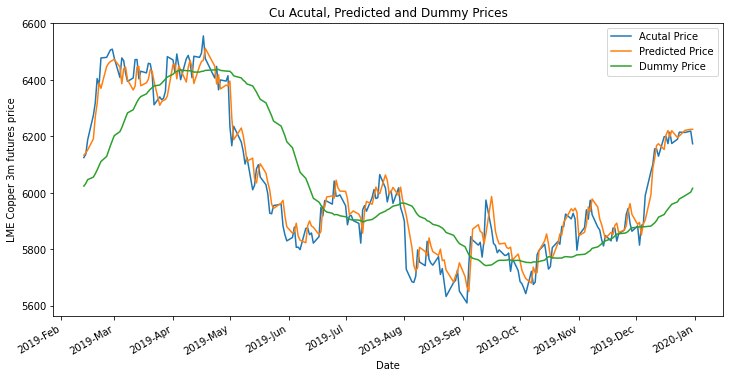

In [ ]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str)

plotter.single_plot()

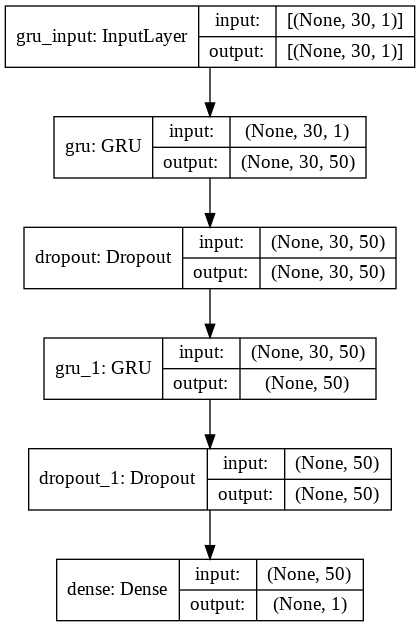

In [ ]:
plot_model(model, show_shapes=True, expand_nested=True)

In [ ]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)

MSE:  0.003450557539754963
RMSE:  0.05874144652419587
MAE:  0.04759080917037845


In [ ]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE:'+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n')
error_file.close()

Mounted at /content/gdrive/


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/GRU_Cu/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/GRU_Cu/assets
